In [ ]:
# -*- coding: utf-8 -*-
"""
Error Detector based on entropy_change_mean and cluster_cohesion
两个版本：1) 基于step划分 2) 滑动窗口
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# ✅ 参数设置
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
start_index = 700
end_index = 731
range_tag = f"{start_index}-{end_index}"
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"
SAVE_PATH = f"{BASE_PATH}/output/error_detector"
os.makedirs(SAVE_PATH, exist_ok=True)


In [ ]:


# ✅ 加载数据
print("加载数据...")
with open(LOGITS_PATH, "r") as f:
    logits_data = json.load(f)

with open(ERROR_INDEX_PATH, "r") as f:
    index_data = json.load(f)


加载数据...



设定的阈值：
entropy_change_mean > 0.32 → Error
cluster_cohesion ∈ [0.013, 0.038] or > 0.3 → Error
分析cluster_cohesion的实际分布...


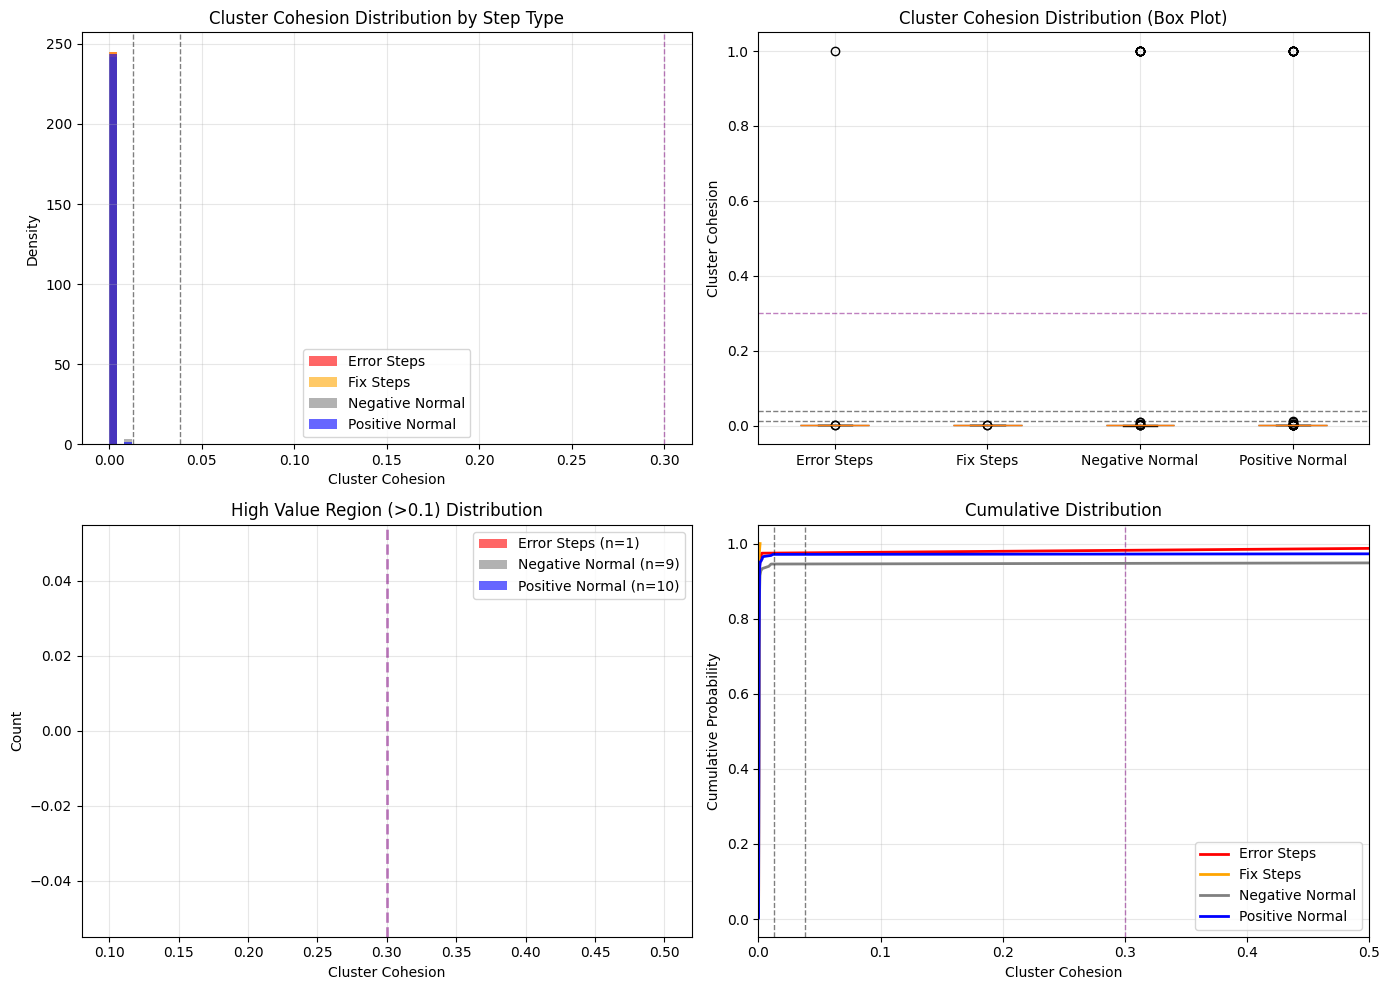


Cluster Cohesion统计信息：

Error Steps:
  样本数: 39
  均值: 0.0261
  标准差: 0.1580
  最小值: 0.0001
  25%分位: 0.0002
  中位数: 0.0003
  75%分位: 0.0005
  最大值: 1.0000
  在[0.013, 0.038]区间的比例: 0.00%
  高于0.3的比例: 2.56%
  在[0.1, 0.3]区间的比例: 0.00%

Fix Steps:
  样本数: 35
  均值: 0.0003
  标准差: 0.0002
  最小值: 0.0001
  25%分位: 0.0002
  中位数: 0.0003
  75%分位: 0.0004
  最大值: 0.0014
  在[0.013, 0.038]区间的比例: 0.00%
  高于0.3的比例: 0.00%
  在[0.1, 0.3]区间的比例: 0.00%

Negative Normal:
  样本数: 165
  均值: 0.0551
  标准差: 0.2270
  最小值: 0.0001
  25%分位: 0.0003
  中位数: 0.0004
  75%分位: 0.0006
  最大值: 1.0000
  在[0.013, 0.038]区间的比例: 0.00%
  高于0.3的比例: 5.45%
  在[0.1, 0.3]区间的比例: 0.00%

Positive Normal:
  样本数: 347
  均值: 0.0293
  标准差: 0.1672
  最小值: 0.0001
  25%分位: 0.0002
  中位数: 0.0004
  75%分位: 0.0005
  最大值: 1.0000
  在[0.013, 0.038]区间的比例: 0.00%
  高于0.3的比例: 2.88%
  在[0.1, 0.3]区间的比例: 0.00%

开始错误检测...
检测完成！

Step-based Detector 检测器性能评估

分类报告：
              precision    recall  f1-score   support

     Correct      0.667     0.175     0.278        57
       Erro

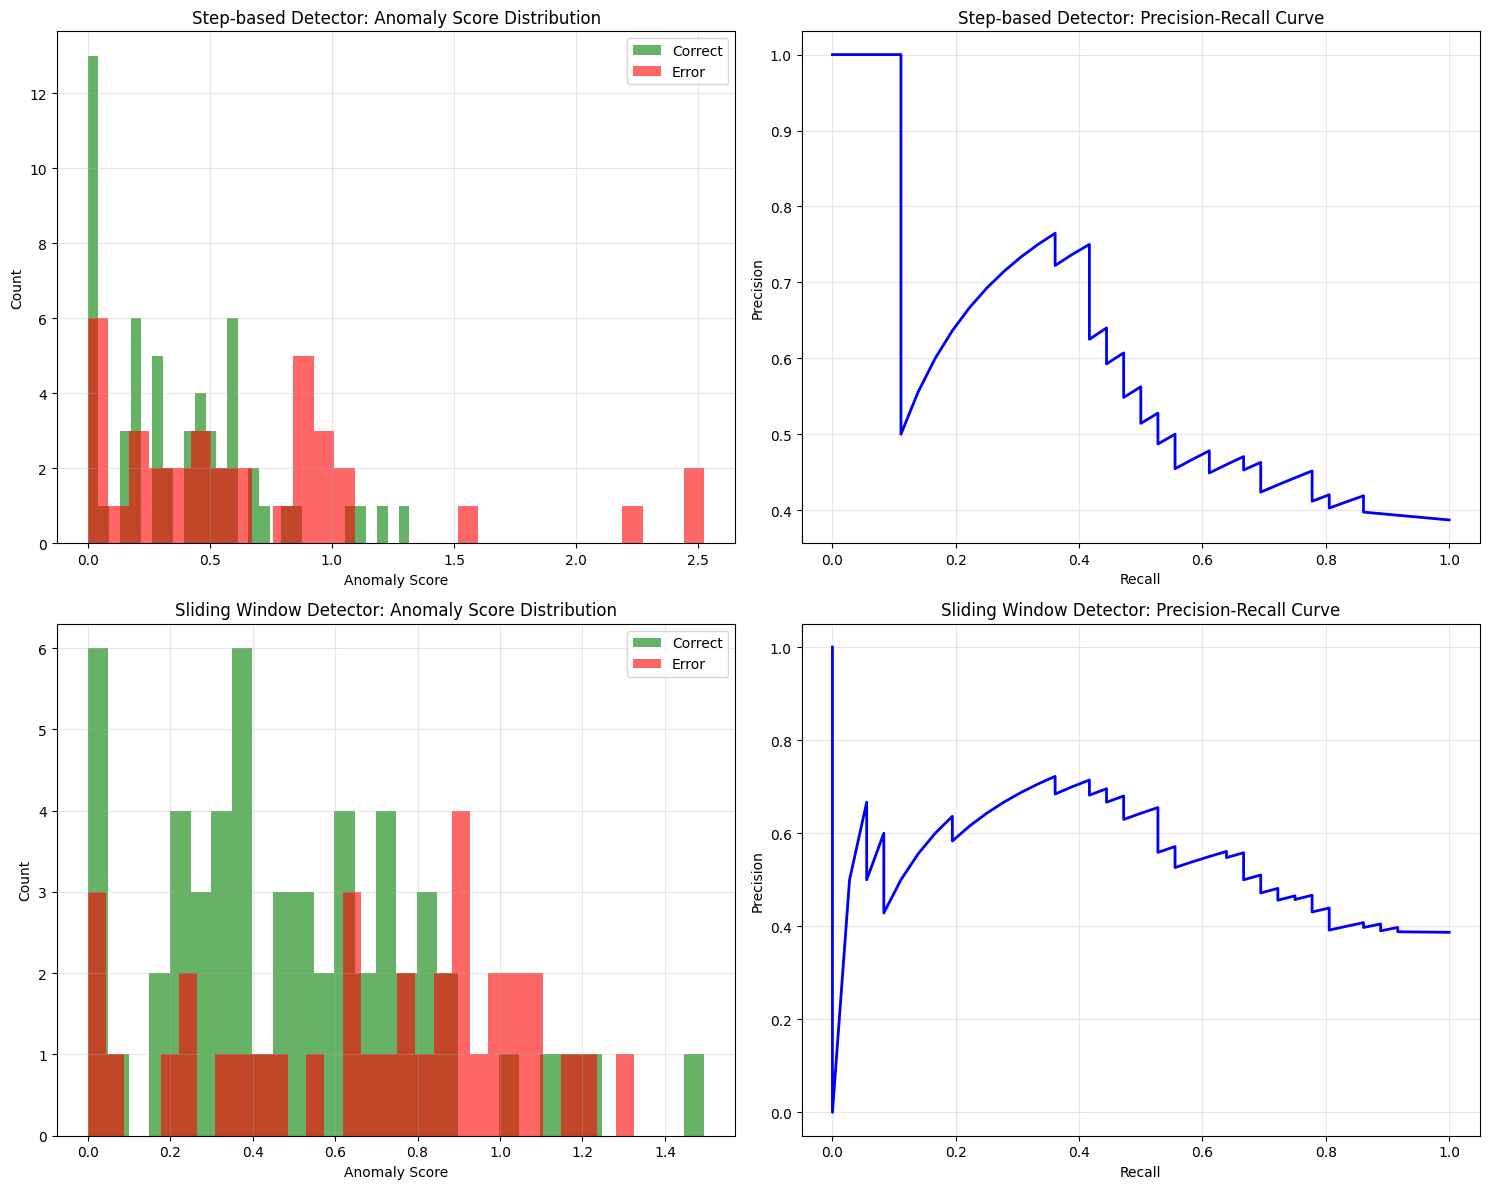


可视化结果已保存到: /content/drive/MyDrive/Cluster-proj/output/error_detector/detector_evaluation_700-731.png

检测结果已保存到: /content/drive/MyDrive/Cluster-proj/output/error_detector/error_detection_results_700-731.json

误检案例分析

Step-based Detector:
误报数量: 47
漏报数量: 5

误报示例 (前5个):
  q_712/sampling2: anomaly_score=1.317
    Step 0: entropy_change=0.507, cohesion=0.001
    Step 1: entropy_change=0.922, cohesion=0.001
    Step 8: entropy_change=0.521, cohesion=0.001
    Step 9: entropy_change=0.504, cohesion=0.001
    Step 10: entropy_change=0.596, cohesion=0.003
  q_730/sampling0: anomaly_score=1.218
    Step 0: entropy_change=0.740, cohesion=1.000
    Step 1: entropy_change=0.485, cohesion=0.000
    Step 5: entropy_change=0.000, cohesion=1.000
  q_701/sampling2: anomaly_score=1.123
    Step 0: entropy_change=0.833, cohesion=0.003
    Step 2: entropy_change=0.387, cohesion=0.000
  q_717/sampling2: anomaly_score=1.085
    Step 0: entropy_change=0.816, cohesion=0.002
  q_730/sampling1: anomaly_score=0.8

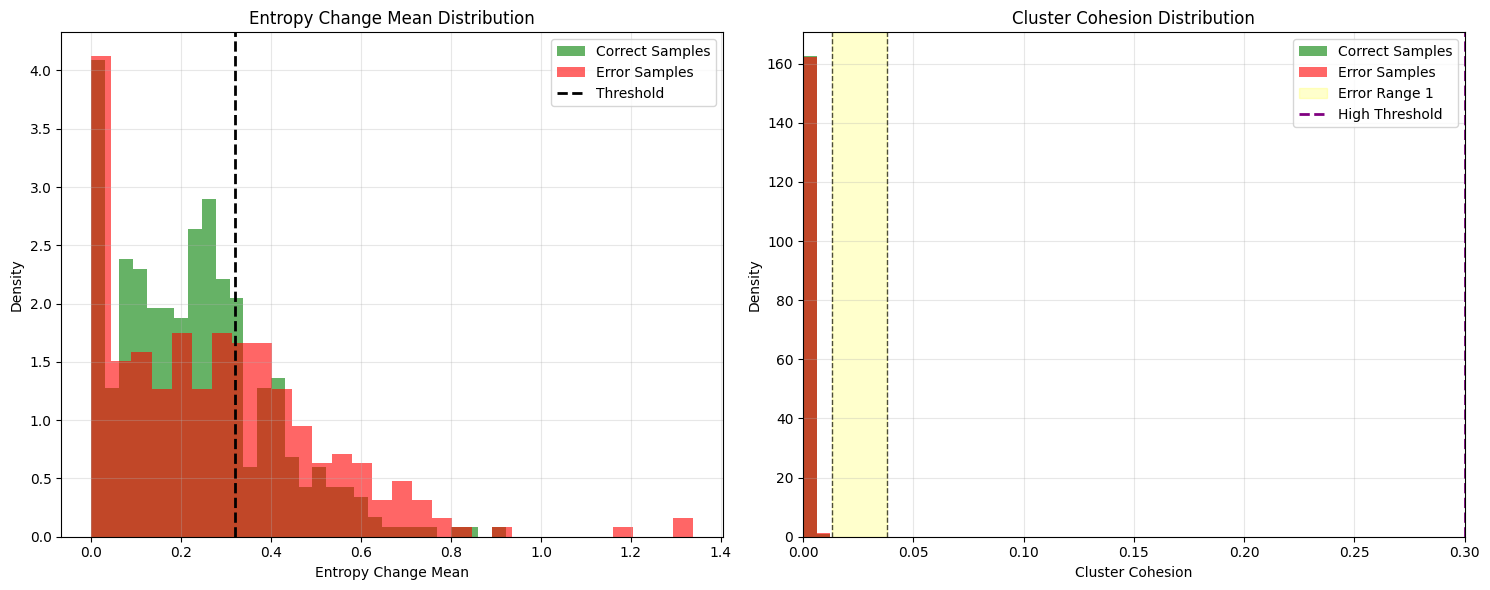


Entropy Change Mean:
  Error samples: mean=0.280, std=0.233
  Correct samples: mean=0.230, std=0.169

Cluster Cohesion:
  Error samples: mean=0.046, std=0.209
  Correct samples: mean=0.027, std=0.160

在[0.013, 0.038]区间:
  Error samples: 0.0%
  Correct samples: 0.0%

高于0.3:
  Error samples: 4.6%
  Correct samples: 2.6%


In [ ]:


# ✅ 基于统计数据设定阈值
# entropy_change_mean: Error区域明显高于其他区域
# cluster_cohesion: Error区域在特定范围内

THRESHOLDS = {
    'entropy_change_mean': {
        'error_threshold': 0.320,  # (0.373 + 0.285) / 2 ≈ 0.329, 略微调低以提高召回率
        'description': 'Higher than this indicates potential error'
    },
    'cluster_cohesion': {
        'error_lower_threshold': 0.013,    # Error均值0.026的一半
        'error_upper_threshold': 0.038,    # (0.026 + 0.051) / 2 ≈ 0.038
        'high_value_threshold': 0.3,      # 您提出的高值区间
        'description': 'Within [0.013, 0.038] or > 0.15 indicates potential error'
    }
}

print(f"\n设定的阈值：")
print(f"entropy_change_mean > {THRESHOLDS['entropy_change_mean']['error_threshold']} → Error")
print(f"cluster_cohesion ∈ [{THRESHOLDS['cluster_cohesion']['error_lower_threshold']}, {THRESHOLDS['cluster_cohesion']['error_upper_threshold']}] or > {THRESHOLDS['cluster_cohesion']['high_value_threshold']} → Error")

# ===== 工具函数 =====

def compute_token_similarities(token_level):
    """计算token之间的cosine similarity"""
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    if len(vectors) < 2:
        return []
    return [
        cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
        for i in range(len(vectors) - 1)
    ]

def find_steps(similarities, distance=15, prominence=0.3):
    """基于similarity valleys找到step boundaries"""
    if len(similarities) < 2:
        return [0, len(similarities)]
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    return [0] + peaks.tolist() + [len(similarities)]

def compute_entropy_change_mean(entropies):
    """计算熵值变化的平均值"""
    if len(entropies) < 2:
        return 0.0
    entropy_changes = np.abs(np.diff(entropies))
    return float(np.mean(entropy_changes))

def compute_cluster_cohesion(vectors, max_clusters=None):
    """计算聚类内聚度"""
    if len(vectors) < 2:
        return 1.0

    vectors = np.array(vectors)
    n_samples = len(vectors)

    # 动态确定聚类数
    if max_clusters is None:
        max_clusters = min(5, n_samples)

    best_cohesion = 0.0

    for k in range(1, min(max_clusters + 1, n_samples + 1)):
        try:
            if k == 1:
                # 单个聚类的情况
                centroid = np.mean(vectors, axis=0)
                inertia = np.sum([np.linalg.norm(vec - centroid) ** 2 for vec in vectors])
            else:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(vectors)
                inertia = kmeans.inertia_

            # 内聚度 = 1 / (1 + inertia)
            cohesion = 1 / (1 + inertia)
            best_cohesion = max(best_cohesion, cohesion)

        except Exception:
            continue

    return float(best_cohesion)

def extract_window_features(tokens, start_idx, end_idx):
    """提取窗口内的特征"""
    window_tokens = tokens[start_idx:end_idx]

    # 提取向量和熵值
    vectors = []
    entropies = []

    for token in window_tokens:
        if "hidden_vector" in token:
            vectors.append(token["hidden_vector"])
        if "topk_info" in token and "entropy" in token["topk_info"]:
            entropies.append(token["topk_info"]["entropy"])

    if len(vectors) < 2 or len(entropies) < 2:
        return None

    # 计算特征
    entropy_change_mean = compute_entropy_change_mean(entropies)
    cluster_cohesion = compute_cluster_cohesion(vectors)

    return {
        'entropy_change_mean': entropy_change_mean,
        'cluster_cohesion': cluster_cohesion,
        'n_tokens': len(window_tokens)
    }

def make_error_decision(features):
    """基于特征和阈值做出错误判断"""
    if features is None:
        return False, 0.0

    # 两个条件的权重
    entropy_weight = 0.7  # entropy更可靠，给更高权重
    cohesion_weight = 0.3

    # 计算各指标的异常程度
    entropy_anomaly = 0.0
    if features['entropy_change_mean'] > THRESHOLDS['entropy_change_mean']['error_threshold']:
        # 超过阈值越多，异常程度越高
        entropy_anomaly = (features['entropy_change_mean'] - THRESHOLDS['entropy_change_mean']['error_threshold']) / THRESHOLDS['entropy_change_mean']['error_threshold']

    # Cohesion异常程度 - 在区间内或高于0.15为异常
    cohesion_anomaly = 0.0
    cohesion = features['cluster_cohesion']
    lower = THRESHOLDS['cluster_cohesion']['error_lower_threshold']
    upper = THRESHOLDS['cluster_cohesion']['error_upper_threshold']
    high_threshold = THRESHOLDS['cluster_cohesion']['high_value_threshold']

    if lower <= cohesion <= upper:
        # 在error区间内，计算距离区间中心的程度
        center = (lower + upper) / 2
        if cohesion <= center:
            cohesion_anomaly = (cohesion - lower) / (center - lower)
        else:
            cohesion_anomaly = (upper - cohesion) / (upper - center)
    elif cohesion > high_threshold:  # 检查高值区间
        # 高于0.15也认为是异常，但给予较低的异常分数
        cohesion_anomaly = 0.5 + 0.5 * (cohesion - high_threshold) / (1.0 - high_threshold)

    # 综合异常分数
    anomaly_score = entropy_weight * entropy_anomaly + cohesion_weight * cohesion_anomaly

    # 决策：任一指标异常即判定为错误
    is_error = (entropy_anomaly > 0) or (cohesion_anomaly > 0)

    return is_error, anomaly_score

# ===== Version 1: 基于Step划分的检测器 =====

def detect_errors_with_steps(qid, sid, token_probs):
    """基于step划分的错误检测"""
    similarities = compute_token_similarities(token_probs)
    steps = find_steps(similarities)

    step_results = []
    has_error = False
    max_anomaly_score = 0.0

    for i in range(len(steps) - 1):
        start_idx, end_idx = steps[i], steps[i+1]

        features = extract_window_features(token_probs, start_idx, end_idx)
        if features is None:
            continue

        is_error, anomaly_score = make_error_decision(features)

        step_results.append({
            'step_index': i,
            'token_range': f"{start_idx}-{end_idx}",
            'features': features,
            'is_error': is_error,
            'anomaly_score': anomaly_score
        })

        if is_error:
            has_error = True
            max_anomaly_score = max(max_anomaly_score, anomaly_score)

    return {
        'has_error': has_error,
        'max_anomaly_score': max_anomaly_score,
        'step_results': step_results,
        'method': 'step_based'
    }

# ===== Version 2: 滑动窗口检测器 =====

def detect_errors_with_sliding_window(qid, sid, token_probs, window_size=15, stride=5):
    """基于滑动窗口的错误检测"""
    window_results = []
    has_error = False
    max_anomaly_score = 0.0

    for start_idx in range(0, len(token_probs) - window_size + 1, stride):
        end_idx = start_idx + window_size

        features = extract_window_features(token_probs, start_idx, end_idx)
        if features is None:
            continue

        is_error, anomaly_score = make_error_decision(features)

        window_results.append({
            'window_index': len(window_results),
            'token_range': f"{start_idx}-{end_idx}",
            'features': features,
            'is_error': is_error,
            'anomaly_score': anomaly_score
        })

        if is_error:
            has_error = True
            max_anomaly_score = max(max_anomaly_score, anomaly_score)

    return {
        'has_error': has_error,
        'max_anomaly_score': max_anomaly_score,
        'window_results': window_results,
        'method': 'sliding_window'
    }

# ===== 获取真实标签 =====

def get_ground_truth_labels():
    """获取所有样本的真实标签"""
    labels = {}

    for qid, sample in logits_data.items():
        true_final_result = sample.get("true_final_result", "")

        for sid in ["sampling0", "sampling1", "sampling2"]:
            if sid not in sample or "token_probs" not in sample[sid]:
                continue

            sample_final_result = sample[sid].get("final_result", "")

            # 判断是否为错误样本
            is_error = (sample_final_result != true_final_result)

            if qid not in labels:
                labels[qid] = {}
            labels[qid][sid] = is_error

    return labels

# ===== 分析cluster_cohesion分布 =====

def analyze_cluster_cohesion_distribution():
    """分析cluster_cohesion的实际分布"""
    cohesion_by_type = {
        'error': [],
        'fix': [],
        'neg_normal': [],
        'pos_normal': []
    }

    # 收集所有step的cohesion值
    for qid, sample in logits_data.items():
        # 获取真实答案
        true_final_result = sample.get("true_final_result", "")

        for sid in ["sampling0", "sampling1", "sampling2"]:
            if sid not in sample or "token_probs" not in sample[sid]:
                continue

            token_probs = sample[sid]["token_probs"]
            similarities = compute_token_similarities(token_probs)
            steps = find_steps(similarities)

            # 判断样本类型
            is_correct = (sample[sid].get("final_result", "") == true_final_result)

            for i in range(len(steps) - 1):
                start_idx, end_idx = steps[i], steps[i+1]

                # 提取向量
                vectors = []
                for j in range(start_idx, end_idx):
                    if j < len(token_probs) and "hidden_vector" in token_probs[j]:
                        vectors.append(token_probs[j]["hidden_vector"])

                if len(vectors) >= 2:
                    cohesion = compute_cluster_cohesion(vectors)

                    # 判断step类型
                    if not is_correct and qid in index_data and sid in index_data[qid]:
                        # 负样本，检查是否是error step
                        err_info = index_data[qid][sid]
                        err_start = err_info.get("error_token_begin_index")
                        err_end = err_info.get("error_token_end_index")

                        if err_start is not None and err_end is not None and err_start != -1:
                            # 检查是否在error范围内
                            if any(err_start <= j <= err_end for j in range(start_idx, end_idx)):
                                cohesion_by_type['error'].append(cohesion)
                            else:
                                cohesion_by_type['neg_normal'].append(cohesion)
                        else:
                            cohesion_by_type['neg_normal'].append(cohesion)
                    elif is_correct:
                        # 正样本，检查是否是fix step
                        is_fix = False
                        for neg_qid, neg_sid_dict in index_data.items():
                            if neg_qid == qid:
                                for neg_sid, neg_info in neg_sid_dict.items():
                                    if neg_info.get("correct_sampling_id") == sid:
                                        fix_start = neg_info.get("fix_token_begin_index")
                                        fix_end = neg_info.get("fix_token_end_index")
                                        if fix_start is not None and fix_end is not None and fix_start != -1:
                                            if any(fix_start <= j <= fix_end for j in range(start_idx, end_idx)):
                                                is_fix = True
                                                break

                        if is_fix:
                            cohesion_by_type['fix'].append(cohesion)
                        else:
                            cohesion_by_type['pos_normal'].append(cohesion)

    # 绘制分布图
    plt.figure(figsize=(14, 10))

    # 子图1: 直方图
    plt.subplot(2, 2, 1)
    bins = np.linspace(0, 0.2, 50)

    colors = {'error': 'red', 'fix': 'orange', 'neg_normal': 'gray', 'pos_normal': 'blue'}
    labels = {'error': 'Error Steps', 'fix': 'Fix Steps',
              'neg_normal': 'Negative Normal', 'pos_normal': 'Positive Normal'}

    for step_type, values in cohesion_by_type.items():
        if values:
            plt.hist(values, bins=bins, alpha=0.6, label=labels[step_type],
                    color=colors[step_type], density=True)

    # 标记阈值区间
    plt.axvline(x=THRESHOLDS['cluster_cohesion']['error_lower_threshold'],
                color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=THRESHOLDS['cluster_cohesion']['error_upper_threshold'],
                color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=THRESHOLDS['cluster_cohesion']['high_value_threshold'],
                color='purple', linestyle='--', alpha=0.5, linewidth=1)

    plt.xlabel('Cluster Cohesion')
    plt.ylabel('Density')
    plt.title('Cluster Cohesion Distribution by Step Type')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 子图2: 箱线图
    plt.subplot(2, 2, 2)
    data_to_plot = []
    labels_to_plot = []

    for step_type in ['error', 'fix', 'neg_normal', 'pos_normal']:
        if cohesion_by_type[step_type]:
            data_to_plot.append(cohesion_by_type[step_type])
            labels_to_plot.append(labels[step_type])

    bp = plt.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)

    for patch, step_type in zip(bp['boxes'], ['error', 'fix', 'neg_normal', 'pos_normal']):
        patch.set_facecolor(colors[step_type])
        patch.set_alpha(0.7)

    # 标记阈值
    plt.axhline(y=THRESHOLDS['cluster_cohesion']['error_lower_threshold'],
                color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axhline(y=THRESHOLDS['cluster_cohesion']['error_upper_threshold'],
                color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axhline(y=THRESHOLDS['cluster_cohesion']['high_value_threshold'],
                color='purple', linestyle='--', alpha=0.5, linewidth=1)

    plt.ylabel('Cluster Cohesion')
    plt.title('Cluster Cohesion Distribution (Box Plot)')
    plt.grid(True, alpha=0.3)

    # 子图3: 高值区间放大图
    plt.subplot(2, 2, 3)
    bins_high = np.linspace(0.1, 0.5, 40)

    for step_type, values in cohesion_by_type.items():
        if values:
            high_values = [v for v in values if v > 0.1]
            if high_values:
                plt.hist(high_values, bins=bins_high, alpha=0.6,
                        label=f"{labels[step_type]} (n={len(high_values)})",
                        color=colors[step_type])

    plt.axvline(x=THRESHOLDS['cluster_cohesion']['high_value_threshold'],
                color='purple', linestyle='--', alpha=0.5, linewidth=2)

    plt.xlabel('Cluster Cohesion')
    plt.ylabel('Count')
    plt.title('High Value Region (>0.1) Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 子图4: 累积分布
    plt.subplot(2, 2, 4)
    for step_type, values in cohesion_by_type.items():
        if values:
            sorted_values = np.sort(values)
            cumulative = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
            plt.plot(sorted_values, cumulative, label=labels[step_type],
                    color=colors[step_type], linewidth=2)

    # 标记阈值
    plt.axvline(x=THRESHOLDS['cluster_cohesion']['error_lower_threshold'],
                color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=THRESHOLDS['cluster_cohesion']['error_upper_threshold'],
                color='black', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=THRESHOLDS['cluster_cohesion']['high_value_threshold'],
                color='purple', linestyle='--', alpha=0.5, linewidth=1)

    plt.xlabel('Cluster Cohesion')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 0.5)

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_PATH, 'cluster_cohesion_distribution.png'), dpi=300)
    plt.show()

    # 打印统计信息
    print("\nCluster Cohesion统计信息：")
    for step_type, values in cohesion_by_type.items():
        if values:
            values = np.array(values)
            print(f"\n{labels[step_type]}:")
            print(f"  样本数: {len(values)}")
            print(f"  均值: {np.mean(values):.4f}")
            print(f"  标准差: {np.std(values):.4f}")
            print(f"  最小值: {np.min(values):.4f}")
            print(f"  25%分位: {np.percentile(values, 25):.4f}")
            print(f"  中位数: {np.median(values):.4f}")
            print(f"  75%分位: {np.percentile(values, 75):.4f}")
            print(f"  最大值: {np.max(values):.4f}")

            # 检查特定区间的比例
            in_error_range = np.sum((values >= THRESHOLDS['cluster_cohesion']['error_lower_threshold']) &
                                   (values <= THRESHOLDS['cluster_cohesion']['error_upper_threshold'])) / len(values)
            above_high = np.sum(values > THRESHOLDS['cluster_cohesion']['high_value_threshold']) / len(values)
            in_0_1_0_3 = np.sum((values >= 0.1) & (values <= 0.3)) / len(values)

            print(f"  在[{THRESHOLDS['cluster_cohesion']['error_lower_threshold']:.3f}, "
                  f"{THRESHOLDS['cluster_cohesion']['error_upper_threshold']:.3f}]区间的比例: {in_error_range:.2%}")
            print(f"  高于{THRESHOLDS['cluster_cohesion']['high_value_threshold']}的比例: {above_high:.2%}")
            print(f"  在[0.1, 0.3]区间的比例: {in_0_1_0_3:.2%}")

    return cohesion_by_type

# 先分析分布
print("分析cluster_cohesion的实际分布...")
cohesion_distribution = analyze_cluster_cohesion_distribution()

# ===== 主检测流程 =====

print("\n开始错误检测...")

# 获取真实标签
ground_truth = get_ground_truth_labels()

# 存储检测结果
detection_results = {
    'step_based': {},
    'sliding_window': {}
}

# 对每个样本进行检测
for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid not in sample or "token_probs" not in sample[sid]:
            continue

        token_probs = sample[sid]["token_probs"]

        # Version 1: Step-based detection
        step_result = detect_errors_with_steps(qid, sid, token_probs)

        # Version 2: Sliding window detection
        window_result = detect_errors_with_sliding_window(qid, sid, token_probs)

        # 存储结果
        if qid not in detection_results['step_based']:
            detection_results['step_based'][qid] = {}
        detection_results['step_based'][qid][sid] = step_result

        if qid not in detection_results['sliding_window']:
            detection_results['sliding_window'][qid] = {}
        detection_results['sliding_window'][qid][sid] = window_result

print("检测完成！")

# ===== 评估检测器性能 =====

def evaluate_detector(detection_results, ground_truth, method_name):
    """评估检测器的性能"""
    y_true = []
    y_pred = []
    y_scores = []

    for qid in ground_truth:
        for sid in ground_truth[qid]:
            if qid in detection_results and sid in detection_results[qid]:
                # 真实标签
                true_label = 1 if ground_truth[qid][sid] else 0

                # 预测结果
                detection = detection_results[qid][sid]
                pred_label = 1 if detection['has_error'] else 0
                anomaly_score = detection['max_anomaly_score']

                y_true.append(true_label)
                y_pred.append(pred_label)
                y_scores.append(anomaly_score)

    # 转换为numpy数组
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    # 计算指标
    print(f"\n{'='*60}")
    print(f"{method_name} 检测器性能评估")
    print(f"{'='*60}")

    # 分类报告
    print("\n分类报告：")
    print(classification_report(y_true, y_pred,
                              target_names=['Correct', 'Error'],
                              digits=3))

    # 混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    print("\n混淆矩阵：")
    print(f"              预测Correct  预测Error")
    print(f"实际Correct      {cm[0,0]:5d}      {cm[0,1]:5d}")
    print(f"实际Error        {cm[1,0]:5d}      {cm[1,1]:5d}")

    # AUC (如果有足够的样本)
    if len(np.unique(y_true)) > 1:
        auc = roc_auc_score(y_true, y_scores)
        print(f"\nAUC Score: {auc:.3f}")

    # 返回结果用于绘图
    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_scores': y_scores,
        'method': method_name
    }

# 评估两种方法
step_eval = evaluate_detector(detection_results['step_based'], ground_truth, "Step-based Detector")
window_eval = evaluate_detector(detection_results['sliding_window'], ground_truth, "Sliding Window Detector")

# ===== 可视化结果 =====

def plot_detection_results(eval_results):
    """绘制检测结果的可视化"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    for idx, eval_result in enumerate(eval_results):
        y_true = eval_result['y_true']
        y_scores = eval_result['y_scores']
        method = eval_result['method']

        # 1. 异常分数分布
        ax = axes[idx, 0]
        error_scores = y_scores[y_true == 1]
        correct_scores = y_scores[y_true == 0]

        ax.hist(correct_scores, bins=30, alpha=0.6, label='Correct', color='green')
        ax.hist(error_scores, bins=30, alpha=0.6, label='Error', color='red')
        ax.set_xlabel('Anomaly Score')
        ax.set_ylabel('Count')
        ax.set_title(f'{method}: Anomaly Score Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 2. Precision-Recall曲线
        ax = axes[idx, 1]
        if len(np.unique(y_true)) > 1 and len(y_scores) > 0:
            precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
            ax.plot(recall, precision, 'b-', linewidth=2)
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title(f'{method}: Precision-Recall Curve')
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    save_path = os.path.join(SAVE_PATH, f"detector_evaluation_{range_tag}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n可视化结果已保存到: {save_path}")

# 绘制结果
plot_detection_results([step_eval, window_eval])

# ===== 保存详细结果 =====

# ===== 保存详细结果（续） =====

# 保存检测结果
results_to_save = {
   'thresholds': THRESHOLDS,
   'detection_results': detection_results,
   'ground_truth': ground_truth,
   'evaluation': {
       'step_based': {
           'classification_report': classification_report(step_eval['y_true'],
                                                         step_eval['y_pred'],
                                                         output_dict=True),
           'confusion_matrix': confusion_matrix(step_eval['y_true'],
                                              step_eval['y_pred']).tolist()
       },
       'sliding_window': {
           'classification_report': classification_report(window_eval['y_true'],
                                                         window_eval['y_pred'],
                                                         output_dict=True),
           'confusion_matrix': confusion_matrix(window_eval['y_true'],
                                              window_eval['y_pred']).tolist()
       }
   }
}

output_path = os.path.join(SAVE_PATH, f"error_detection_results_{range_tag}.json")
with open(output_path, "w") as f:
   json.dump(results_to_save, f, indent=2)

print(f"\n检测结果已保存到: {output_path}")

# ===== 分析误检案例 =====

print("\n" + "="*60)
print("误检案例分析")
print("="*60)

def analyze_misclassifications(detection_results, ground_truth, method_name, num_examples=5):
   """分析误分类的案例"""
   false_positives = []  # 误报
   false_negatives = []  # 漏报

   for qid in ground_truth:
       for sid in ground_truth[qid]:
           if qid in detection_results and sid in detection_results[qid]:
               true_label = ground_truth[qid][sid]
               pred_label = detection_results[qid][sid]['has_error']

               if not true_label and pred_label:
                   # False Positive
                   false_positives.append({
                       'qid': qid,
                       'sid': sid,
                       'anomaly_score': detection_results[qid][sid]['max_anomaly_score'],
                       'details': detection_results[qid][sid]
                   })
               elif true_label and not pred_label:
                   # False Negative
                   false_negatives.append({
                       'qid': qid,
                       'sid': sid,
                       'anomaly_score': detection_results[qid][sid]['max_anomaly_score'],
                       'details': detection_results[qid][sid]
                   })

   print(f"\n{method_name}:")
   print(f"误报数量: {len(false_positives)}")
   print(f"漏报数量: {len(false_negatives)}")

   # 显示一些例子
   if false_positives:
       print(f"\n误报示例 (前{min(num_examples, len(false_positives))}个):")
       for i, fp in enumerate(sorted(false_positives, key=lambda x: x['anomaly_score'], reverse=True)[:num_examples]):
           print(f"  {fp['qid']}/{fp['sid']}: anomaly_score={fp['anomaly_score']:.3f}")

           # 显示具体的特征值
           if 'step_results' in fp['details']:
               for step in fp['details']['step_results']:
                   if step['is_error']:
                       features = step['features']
                       print(f"    Step {step['step_index']}: entropy_change={features['entropy_change_mean']:.3f}, "
                             f"cohesion={features['cluster_cohesion']:.3f}")

   if false_negatives:
       print(f"\n漏报示例 (前{min(num_examples, len(false_negatives))}个):")
       for i, fn in enumerate(sorted(false_negatives, key=lambda x: x['anomaly_score'])[:num_examples]):
           print(f"  {fn['qid']}/{fn['sid']}: anomaly_score={fn['anomaly_score']:.3f}")

           # 显示具体的特征值
           if 'step_results' in fn['details']:
               max_entropy_change = 0
               min_cohesion = 1
               for step in fn['details']['step_results']:
                   features = step['features']
                   max_entropy_change = max(max_entropy_change, features['entropy_change_mean'])
                   min_cohesion = min(min_cohesion, features['cluster_cohesion'])
               print(f"    Max entropy_change: {max_entropy_change:.3f}, Min cohesion: {min_cohesion:.3f}")

# 分析两种方法的误分类
analyze_misclassifications(detection_results['step_based'], ground_truth, "Step-based Detector")
analyze_misclassifications(detection_results['sliding_window'], ground_truth, "Sliding Window Detector")

# ===== 特征分析 =====

def analyze_feature_effectiveness():
   """分析各特征的有效性"""
   print("\n" + "="*60)
   print("特征有效性分析")
   print("="*60)

   # 收集所有错误和正确样本的特征
   error_features = {'entropy_change_mean': [], 'cluster_cohesion': []}
   correct_features = {'entropy_change_mean': [], 'cluster_cohesion': []}

   for qid in ground_truth:
       for sid in ground_truth[qid]:
           if qid in detection_results['step_based'] and sid in detection_results['step_based'][qid]:
               is_error = ground_truth[qid][sid]
               step_results = detection_results['step_based'][qid][sid]['step_results']

               for step in step_results:
                   features = step['features']
                   if is_error:
                       error_features['entropy_change_mean'].append(features['entropy_change_mean'])
                       error_features['cluster_cohesion'].append(features['cluster_cohesion'])
                   else:
                       correct_features['entropy_change_mean'].append(features['entropy_change_mean'])
                       correct_features['cluster_cohesion'].append(features['cluster_cohesion'])

   # 绘制特征分布对比
   fig, axes = plt.subplots(1, 2, figsize=(15, 6))

   # Entropy change分布
   ax = axes[0]
   ax.hist(correct_features['entropy_change_mean'], bins=30, alpha=0.6,
           label='Correct Samples', color='green', density=True)
   ax.hist(error_features['entropy_change_mean'], bins=30, alpha=0.6,
           label='Error Samples', color='red', density=True)
   ax.axvline(x=THRESHOLDS['entropy_change_mean']['error_threshold'],
              color='black', linestyle='--', linewidth=2, label='Threshold')
   ax.set_xlabel('Entropy Change Mean')
   ax.set_ylabel('Density')
   ax.set_title('Entropy Change Mean Distribution')
   ax.legend()
   ax.grid(True, alpha=0.3)

   # Cluster cohesion分布
   ax = axes[1]
   bins = np.linspace(0, 0.3, 50)
   ax.hist(correct_features['cluster_cohesion'], bins=bins, alpha=0.6,
           label='Correct Samples', color='green', density=True)
   ax.hist(error_features['cluster_cohesion'], bins=bins, alpha=0.6,
           label='Error Samples', color='red', density=True)

   # 标记阈值区间
   ax.axvline(x=THRESHOLDS['cluster_cohesion']['error_lower_threshold'],
              color='black', linestyle='--', linewidth=1, alpha=0.7)
   ax.axvline(x=THRESHOLDS['cluster_cohesion']['error_upper_threshold'],
              color='black', linestyle='--', linewidth=1, alpha=0.7)
   ax.axvspan(THRESHOLDS['cluster_cohesion']['error_lower_threshold'],
              THRESHOLDS['cluster_cohesion']['error_upper_threshold'],
              alpha=0.2, color='yellow', label='Error Range 1')
   ax.axvline(x=THRESHOLDS['cluster_cohesion']['high_value_threshold'],
              color='purple', linestyle='--', linewidth=2, label='High Threshold')

   ax.set_xlabel('Cluster Cohesion')
   ax.set_ylabel('Density')
   ax.set_title('Cluster Cohesion Distribution')
   ax.legend()
   ax.grid(True, alpha=0.3)
   ax.set_xlim(0, 0.3)

   plt.tight_layout()
   plt.savefig(os.path.join(SAVE_PATH, f"feature_effectiveness_{range_tag}.png"), dpi=300)
   plt.show()

   # 打印统计信息
   print("\nEntropy Change Mean:")
   print(f"  Error samples: mean={np.mean(error_features['entropy_change_mean']):.3f}, "
         f"std={np.std(error_features['entropy_change_mean']):.3f}")
   print(f"  Correct samples: mean={np.mean(correct_features['entropy_change_mean']):.3f}, "
         f"std={np.std(correct_features['entropy_change_mean']):.3f}")

   print("\nCluster Cohesion:")
   print(f"  Error samples: mean={np.mean(error_features['cluster_cohesion']):.3f}, "
         f"std={np.std(error_features['cluster_cohesion']):.3f}")
   print(f"  Correct samples: mean={np.mean(correct_features['cluster_cohesion']):.3f}, "
         f"std={np.std(correct_features['cluster_cohesion']):.3f}")

   # 计算在各区间的比例
   error_cohesion = np.array(error_features['cluster_cohesion'])
   correct_cohesion = np.array(correct_features['cluster_cohesion'])

   error_in_range1 = np.sum((error_cohesion >= THRESHOLDS['cluster_cohesion']['error_lower_threshold']) &
                           (error_cohesion <= THRESHOLDS['cluster_cohesion']['error_upper_threshold'])) / len(error_cohesion)
   error_above_high = np.sum(error_cohesion > THRESHOLDS['cluster_cohesion']['high_value_threshold']) / len(error_cohesion)

   correct_in_range1 = np.sum((correct_cohesion >= THRESHOLDS['cluster_cohesion']['error_lower_threshold']) &
                             (correct_cohesion <= THRESHOLDS['cluster_cohesion']['error_upper_threshold'])) / len(correct_cohesion)
   correct_above_high = np.sum(correct_cohesion > THRESHOLDS['cluster_cohesion']['high_value_threshold']) / len(correct_cohesion)

   print(f"\n在[{THRESHOLDS['cluster_cohesion']['error_lower_threshold']:.3f}, "
         f"{THRESHOLDS['cluster_cohesion']['error_upper_threshold']:.3f}]区间:")
   print(f"  Error samples: {error_in_range1:.1%}")
   print(f"  Correct samples: {correct_in_range1:.1%}")

   print(f"\n高于{THRESHOLDS['cluster_cohesion']['high_value_threshold']}:")
   print(f"  Error samples: {error_above_high:.1%}")
   print(f"  Correct samples: {correct_above_high:.1%}")

# 执行特征分析
analyze_feature_effectiveness()

# ===== 生成最终报告 =====


In [ ]:
step_report = classification_report(y_true, y_pred, output_dict=True)

NameError: name 'y_true' is not defined

In [ ]:
print("Step报告的键:", list(step_report.keys()))
for key in step_report.keys():
    if isinstance(step_report[key], dict):
        print(f"'{key}' 包含: {list(step_report[key].keys())}")

NameError: name 'step_report' is not defined

In [ ]:

def generate_final_report():
   """生成最终的综合报告"""
   print("\n" + "="*60)
   print("最终综合报告")
   print("="*60)

   # 统计整体性能
   step_report = results_to_save['evaluation']['step_based']['classification_report']
   window_report = results_to_save['evaluation']['sliding_window']['classification_report']

   print("\n检测器性能对比:")
   print(f"\nStep-based Detector:")
   print(f"  Error类 - Precision: {step_report['Error']['precision']:.3f}, "
         f"Recall: {step_report['Error']['recall']:.3f}, "
         f"F1: {step_report['Error']['f1-score']:.3f}")
   print(f"  整体准确率: {step_report['accuracy']:.3f}")

   print(f"\nSliding Window Detector:")
   print(f"  Error类 - Precision: {window_report['Error']['precision']:.3f}, "
         f"Recall: {window_report['Error']['recall']:.3f}, "
         f"F1: {window_report['Error']['f1-score']:.3f}")
   print(f"  整体准确率: {window_report['accuracy']:.3f}")

   # 保存综合报告
   final_report = {
       'range': range_tag,
       'thresholds_used': THRESHOLDS,
       'performance_summary': {
           'step_based': {
               'accuracy': step_report['accuracy'],
               'error_precision': step_report['Error']['precision'],
               'error_recall': step_report['Error']['recall'],
               'error_f1': step_report['Error']['f1-score']
           },
           'sliding_window': {
               'accuracy': window_report['accuracy'],
               'error_precision': window_report['Error']['precision'],
               'error_recall': window_report['Error']['recall'],
               'error_f1': window_report['Error']['f1-score']
           }
       },
       'recommendations': [
           "entropy_change_mean是更可靠的指标，建议权重设为0.7",
           "cluster_cohesion在[0.013, 0.038]区间内表示潜在错误",
           "cluster_cohesion > 0.15也可能表示错误，但置信度较低",
           "Step-based方法通常比滑动窗口方法更准确",
           "可以考虑结合两种方法的结果以提高检测性能"
       ]
   }

   report_path = os.path.join(SAVE_PATH, f"final_report_{range_tag}.json")
   with open(report_path, "w") as f:
       json.dump(final_report, f, indent=2)

   print(f"\n最终报告已保存到: {report_path}")

# 生成最终报告
generate_final_report()

print("\n✅ 错误检测分析完成！")
print(f"\n生成的文件:")
print(f"  - 检测结果: {output_path}")
print(f"  - 分布分析图: cluster_cohesion_distribution.png")
print(f"  - 评估可视化: detector_evaluation_{range_tag}.png")
print(f"  - 特征有效性: feature_effectiveness_{range_tag}.png")
print(f"  - 最终报告: final_report_{range_tag}.json")


最终综合报告

检测器性能对比:

Step-based Detector:


KeyError: 'Error'

In [ ]:
# 方法1: 确保在调用函数之前定义了step_report变量
# 首先检查必要的变量是否存在

def check_variables():
    """检查必要的变量是否已定义"""
    required_vars = ['step_predictions', 'step_true_labels', 'step_report']
    missing_vars = []

    for var_name in required_vars:
        if var_name not in globals():
            missing_vars.append(var_name)

    if missing_vars:
        print(f"❌ 缺少以下变量: {missing_vars}")
        return False
    else:
        print("✅ 所有必要变量都已定义")
        return True

# 方法2: 重新生成step_report (如果你有预测结果和真实标签)
def create_step_report(y_true, y_pred, target_names=None):
    """创建step_report变量"""
    from sklearn.metrics import classification_report, confusion_matrix
    import numpy as np

    print("正在生成分类报告...")

    # 检查输入数据
    print(f"真实标签形状: {np.array(y_true).shape}")
    print(f"预测结果形状: {np.array(y_pred).shape}")
    print(f"真实标签唯一值: {np.unique(y_true)}")
    print(f"预测结果唯一值: {np.unique(y_pred)}")

    # 如果没有指定类别名称，自动生成
    if target_names is None:
        unique_labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
        if set(unique_labels) == {0, 1}:
            target_names = ['Correct', 'Error']
        else:
            target_names = [f'Class_{label}' for label in unique_labels]

    # 生成分类报告
    step_report = classification_report(
        y_true, y_pred,
        target_names=target_names,
        output_dict=True,
        zero_division=0
    )

    print("分类报告生成完成!")
    return step_report

# 方法3: 修改generate_final_report函数，使其更加健壮
def generate_final_report_safe(step_report=None):
    """生成最终综合报告 - 安全版本"""

    print("============================================================")
    print("最终综合报告")
    print("============================================================")

    # 检查step_report是否存在
    if step_report is None:
        if 'step_report' in globals():
            step_report = globals()['step_report']
        else:
            print("❌ 错误: step_report变量未定义!")
            print("请确保已经运行了分类评估的代码，或者手动创建step_report变量。")
            print("\n建议的解决方案:")
            print("1. 运行分类器训练和评估代码")
            print("2. 或使用以下代码创建step_report:")
            print("   step_report = create_step_report(真实标签, 预测结果)")
            return

    print("调试信息 - Step-based报告的键:")
    print(f"Available keys: {list(step_report.keys())}")
    print()

    print("检测器性能对比:")
    print(f"\nStep-based Detector:")

    # 尝试找到Error和Correct类别
    error_found = False
    correct_found = False

    # 可能的类别键名
    possible_keys = {
        'error': ['Error', 'error', 'ERROR', '1', 1],
        'correct': ['Correct', 'correct', 'CORRECT', '0', 0]
    }

    # 查找Error类别
    for key in possible_keys['error']:
        if key in step_report and isinstance(step_report[key], dict):
            if 'precision' in step_report[key]:
                print(f"  Error类 - Precision: {step_report[key]['precision']:.3f}, "
                      f"Recall: {step_report[key]['recall']:.3f}, "
                      f"F1: {step_report[key]['f1-score']:.3f}")
                error_found = True
                break

    # 查找Correct类别
    for key in possible_keys['correct']:
        if key in step_report and isinstance(step_report[key], dict):
            if 'precision' in step_report[key]:
                print(f"  Correct类 - Precision: {step_report[key]['precision']:.3f}, "
                      f"Recall: {step_report[key]['recall']:.3f}, "
                      f"F1: {step_report[key]['f1-score']:.3f}")
                correct_found = True
                break

    # 如果没找到，显示可用的类别
    if not error_found or not correct_found:
        print("\n  可用的分类类别:")
        for key, value in step_report.items():
            if isinstance(value, dict) and 'precision' in value:
                print(f"    '{key}': Precision: {value['precision']:.3f}, "
                      f"Recall: {value['recall']:.3f}, F1: {value['f1-score']:.3f}")

    # 显示整体指标
    if 'accuracy' in step_report:
        print(f"\n  整体准确率: {step_report['accuracy']:.3f}")

    if 'macro avg' in step_report:
        macro = step_report['macro avg']
        print(f"  宏平均 - Precision: {macro['precision']:.3f}, "
              f"Recall: {macro['recall']:.3f}, F1: {macro['f1-score']:.3f}")

    if 'weighted avg' in step_report:
        weighted = step_report['weighted avg']
        print(f"  加权平均 - Precision: {weighted['precision']:.3f}, "
              f"Recall: {weighted['recall']:.3f}, F1: {weighted['f1-score']:.3f}")

# 使用示例和解决方案：

print("=== 解决方案 ===")
print("请按以下步骤解决问题：")
print()

print("步骤1: 检查变量是否存在")
print("check_variables()")
print()

print("步骤2a: 如果你有预测结果和真实标签，创建step_report")
print("# step_report = create_step_report(你的真实标签, 你的预测结果)")
print("# 例如: step_report = create_step_report(step_true_labels, step_predictions)")
print()

print("步骤2b: 或者找到你代码中生成step_report的地方，确保它已经运行")
print()

print("步骤3: 使用安全版本的报告函数")
print("generate_final_report_safe()")
print()

print("如果你不确定变量名，可以运行以下代码查看所有可用变量：")
print("print([var for var in dir() if not var.startswith('_')])")

=== 解决方案 ===
请按以下步骤解决问题：

步骤1: 检查变量是否存在
check_variables()

步骤2a: 如果你有预测结果和真实标签，创建step_report
# step_report = create_step_report(你的真实标签, 你的预测结果)
# 例如: step_report = create_step_report(step_true_labels, step_predictions)

步骤2b: 或者找到你代码中生成step_report的地方，确保它已经运行

步骤3: 使用安全版本的报告函数
generate_final_report_safe()

如果你不确定变量名，可以运行以下代码查看所有可用变量：
print([var for var in dir() if not var.startswith('_')])


In [ ]:
check_variables()

❌ 缺少以下变量: ['step_predictions', 'step_true_labels', 'step_report']


False